This is a short notebook describing the problem with `astro_lsst_01_1067.db`. This was a run where we mixed 

In [6]:
import numpy as np
import pandas as pd

In [7]:
from sqlalchemy import create_engine

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [9]:
conn = create_engine('sqlite:///'+ '/Users/rbiswas/data/LSST/OpSimData/astro_lsst_01_1067_sqlite.db', echo=False)

In [11]:
df = pd.read_sql_table('Summary', con=conn)

In [12]:
df.query('propID == 204').fieldID.unique().size

802

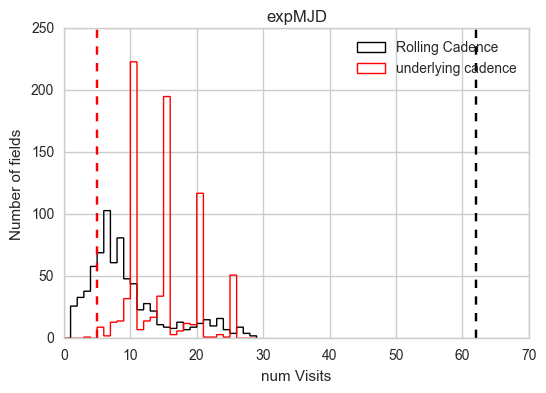

In [19]:
fig, ax = plt.subplots()
df.query('propID == 204 and filter == "r"').groupby('fieldID').agg(dict(expMJD='count'), '').hist(bins=np.arange(0., 30., 1.),
                                                                                                  histtype='step',
                                                                                                  lw=1., 
                                                                                                  ax=ax,
                                                                                                  color='k',
                                                                                                  label='Rolling Cadence',
                                                                                                  alpha=1)
df.query('propID == 210 and filter == "r"').groupby('fieldID').agg(dict(expMJD='count'), '').hist(bins=np.arange(0., 30., 1.),
                                                                                                  histtype='step',
                                                                                                  lw=1.,
                                                                                                  color='r',
                                                                                                  ax=ax,
                                                                                                  label='underlying cadence',
                                                                                                  alpha=1)

plt.legend()
ax.set_xlabel('num Visits')
ax.set_ylabel('Number of fields')
ax.axvline(62, color='k', ls='dashed')
ax.axvline(5, color='r', ls='dashed')

This plot shows a histogram of the number of visits to different fields. The dashed lines show the requested number of visits. It appears that (a) all of the fields are getting observations not leaving enough time and cutting off at the same time. This is apparently because the number of sequences is used to 'stop' awarding sequences to a proposal, but not increase the probability of a proposal which demands many more sequences. Instead that has to be done using propRank. (b) Having `RestartCompletedSequences` implies it does not stop sequences even after they have been completed, and continues to add 5 visit chunks to each field.
We have started a new run with `RestartCompletedSequences` set to `False`, and `MaxBoostToComplete` to 0. on the advice of Lynne.  There is still a worry that the better way to do this is by ranking proposals, because I am worried that the underlying cadence of 5 days will finish too early, particularly for the two year sequences.

The following cells show that the proposals 210 (not observed with concentrated cadence) and 204 (observed with concentrated cadence have expected expMJD / night distribution (2nd year).

In [43]:
df.query('propID == 210 and filter == "r"').night.describe()

count    10974.000000
mean       540.977583
std         98.270935
min        387.000000
25%        451.000000
50%        539.000000
75%        619.000000
max        729.000000
Name: night, dtype: float64

In [44]:
df.query('propID == 204 and filter == "r"').night.describe()

count    6968.000000
mean      536.564581
std        95.595173
min       387.000000
25%       473.000000
50%       531.000000
75%       588.000000
max       714.000000
Name: night, dtype: float64